<a href="https://colab.research.google.com/github/saadrza/XAI/blob/main/Copy_of_XAI_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# *Project Start*


*   Install and Import important Packages
*   Import the model
*   Transform the images
*   Generate Predicitons




# Install and Import Important Packages

In [1]:
%pip install lime
!pip install tensorflow
import os
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split


from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
%matplotlib inline
print('Notebook run using keras:', keras.__version__)
#display
from IPython.display import Image, display


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=df3f3c4a6f021d8427b116432487a00f7c0a4ac76b3b0fda5461ca0b603f3689
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Notebook run using keras: 3.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Assuming your folder is in 'My Drive/my_folder'
folder_path = '/content/drive/My Drive/data_XAI/pancreas/pancreas/'  # Replace with your actual folder path

# List all files in the folder
!ls "{folder_path}"


Mounted at /content/drive
attention_label  image


In [3]:
path= folder_path + "image/"
print(path)


/content/drive/My Drive/data_XAI/pancreas/pancreas/image/




---



In [4]:
batch_size = 16
img_height = 299
img_width = 299

Found 361 files belonging to 2 classes.
Number of training batches:   16
Number of validation batches: 4
Number of testing batches:    3
Total training samples:       256
Total validation samples:     64
Total testing samples:        48


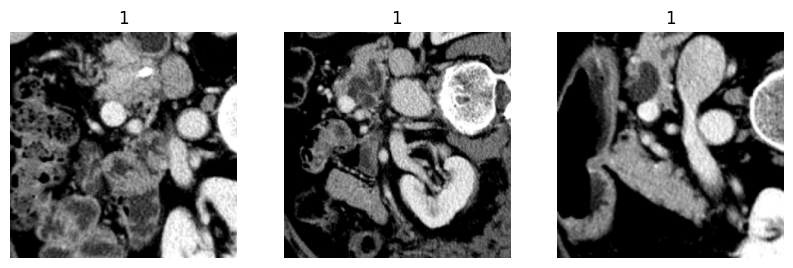

In [5]:
def loading_data(path, batch_size, img_height, img_width, train_ratio, val_ratio):
  # Load the full dataset from both pos and neg folders
  full_ds = tf.keras.preprocessing.image_dataset_from_directory(
      path,
      labels='inferred',
      label_mode='int',
      batch_size=batch_size,
      image_size=(img_height, img_width),
      shuffle=True,
      seed=1
  )

  # Get total number of batches
  num_batches = full_ds.cardinality().numpy()
  train_size = int(train_ratio * num_batches)  # 70% training
  val_size = int(val_ratio * num_batches)    # 20% validation
  test_size = num_batches - train_size - val_size  # 10% testing

  # Split the dataset
  train_ds = full_ds.take(train_size)
  val_ds = full_ds.skip(train_size).take(val_size)
  test_ds = full_ds.skip(train_size + val_size).take(test_size)

  print(f"Number of training batches:   {train_ds.cardinality()}")
  print(f"Number of validation batches: {val_ds.cardinality()}")
  print(f"Number of testing batches:    {test_ds.cardinality()}")

  print(f"Total training samples:       {train_ds.cardinality().numpy() * batch_size}")
  print(f"Total validation samples:     {val_ds.cardinality().numpy() * batch_size}")
  print(f"Total testing samples:        {test_ds.cardinality().numpy() * batch_size}")

   # Plot some images from the training dataset
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):  # Take one batch of images
      for i in range(3):  # Plot the first 9 images
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))  # Extract individual image
          plt.title(int(labels[i])) # Convert label to class name
          plt.axis("off")
  plt.show()

  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = loading_data(path, batch_size, img_height, img_width, train_ratio= 0.7, val_ratio=0.2)

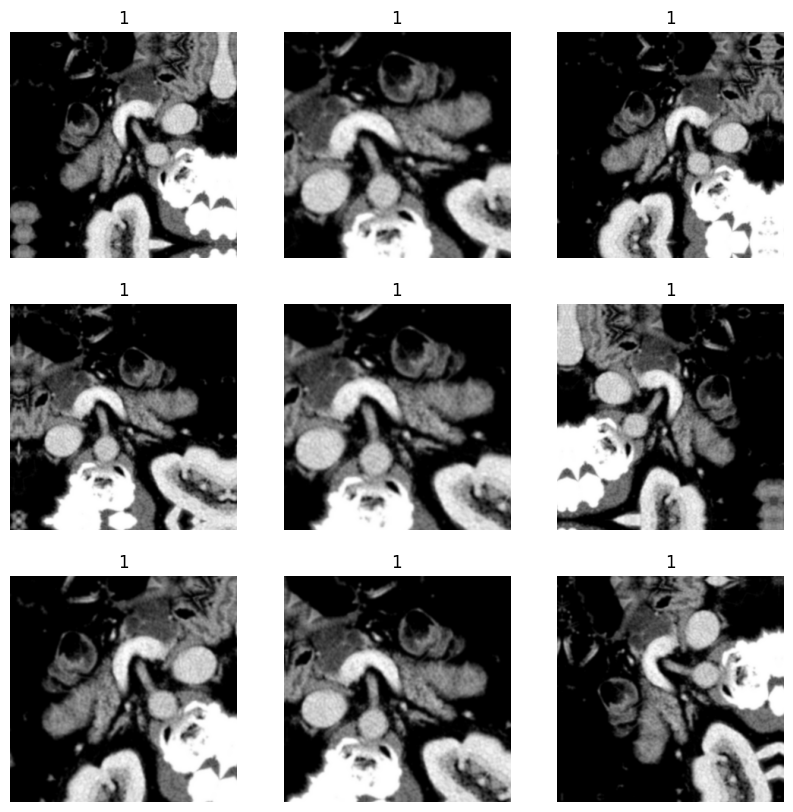

In [6]:
def preprocess_data(train_ds, val_ds, test_ds, resize_dim):

  resize_fn = keras.layers.Resizing(resize_dim, resize_dim)

  train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
  val_ds = val_ds.map(lambda x, y: (resize_fn(x), y))
  test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


  augmentation_layers = [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2),
  ]


  def data_augmentation(x):
      for layer in augmentation_layers:
          x = layer(x)
      return x


  train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

  for images, labels in train_ds.take(1):
      plt.figure(figsize=(10, 10))
      first_image = images[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(np.expand_dims(first_image, 0))
          plt.imshow(np.array(augmented_image[0]).astype("int32"))
          plt.title(int(labels[0]))
          plt.axis("off")

  return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds= preprocess_data(train_ds, val_ds, test_ds, resize_dim= img_width)

# Install the base model and fine tune it

In [7]:
batch_size

16

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

print("Test dataset evaluation")
model.evaluate(test_ds)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 10, 10, 2048)         │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Fitting the top layer of the model
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 186s 11s/step - binary_accuracy: 0.5396 - loss: 0.5740 - val_binary_accuracy: 0.7656 - val_loss: 0.5156
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - binary_accuracy: 0.7997 - loss: 0.4692 - val_binary_accuracy: 0.9375 - val_loss: 0.4223
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 165s 11s/step - binary_accuracy: 0.9105 - loss: 0.3651 - val_binary_accuracy: 1.0000 - val_loss: 0.2543
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 167s 11s/step - binary_accuracy: 0.8984 - loss: 0.3032 - val_binary_accuracy: 0.8906 - val_loss: 0.3097
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - binary_accuracy: 0.9566 - loss: 0.2465 - val_binary_accuracy: 0.8906 - val_loss: 0.2575
Test dataset evaluation
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - binary_accuracy: 0.8887 - loss: 0.3001


[0.27608463168144226, 0.9024389982223511]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=val_ds)
print("Test dataset evaluation")
model.evaluate(test_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 10, 10, 2048)         │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fitting the end-to-end model
Epoch 1/5
11/16 ━━━━━━━━━━━━━━━━━━━━ 2:28 30s/step - binary_accuracy: 0.5217 - loss: 0.5888

KeyboardInterrupt: 

In [ ]:
model.save(path +'./model_xception_batch16_epoch5_imgsize299.keras')
inet_model = model



---





---



In [9]:
path

'/content/drive/My Drive/data_XAI/pancreas/pancreas/image/'

In [10]:
# Load the saved model
loaded_model = keras.models.load_model(path +'./model_xception_batch16_epoch5_imgsize299.keras')

# Print the model summary
print(loaded_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,481,533 (238.35 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 41,618,004 (158.76 MB)

None


In [14]:
model= loaded_model


print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - binary_accuracy: 0.8487 - loss: 0.3305


[0.3284852206707001, 0.8536585569381714]

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input # Correct import for Xception
from keras import layers
from tensorflow import data as tf_dat

#model=base_model= inet_model = load_model('./model_xception_batch16_epoch5.keras')

target_size = (299,299)

# Preprocess the images

## Transform the images

In [ ]:
path

'/content/drive/My Drive/data_XAI/pancreas/pancreas/image/'

In [12]:
folder_path = path+ "pos/"

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import xception

# Your folder path
#folder_path = 'path/to/your/images'

# Transform function
def transform_img_fn(path_list, target_size):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)  # Preprocessing for InceptionV3 (or any other model)
        out.append(x)
    return np.vstack(out)

# Efficient Image Loading
images = []
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        img_path = os.path.join(folder_path, filename)
        # Append transformed image (processed & preprocessed)
        images.append(transform_img_fn([img_path], target_size)[0])

# Convert list to numpy array (final image dataset)
images = np.array(images)

print(f"Processed {len(images)} images.")


Processed 281 images.


## Let's see the top 5 prediction for some image

> Add blockquote



# LIME Implementation


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
def implement_lime(model, image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image[0].astype('double'),
                                             inet_model.predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000
                                             )
    explanation_lime = explanation
    return explanation_lime

In [ ]:
def explain_with_lime(explanation_lime, image, num_features, top_candidate):
    temp, mask = explanation_lime.get_image_and_mask(explanation_lime.top_labels[top_candidate], positive_only=True, num_features= num_features, hide_rest=False, min_weight=0.1)
    plt.figure()
    plt.title("Number of Features= " + str(num_features))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
images

In [ ]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
for i in range(images.shape[0]):
    #plt.figure()

    # Predict for a single image at a time
    pred = inet_model.predict(images[i:i+1])

    # Print the prediction (it will be a single value)
    #print(f"Prediction for image {i}: {pred[0][0]}")

    # Display the image (if needed)
    #plt.imshow(images[i] / 2 + 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
explanation_lime = implement_lime(model, images)
explain_with_lime(explanation_lime, images, num_features=15, top_candidate=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

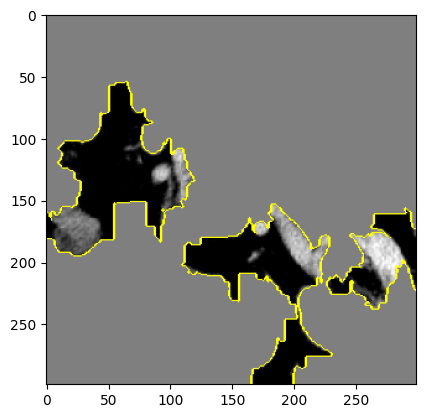

In [ ]:
temp, mask = explanation_lime.get_image_and_mask(explanation_lime.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

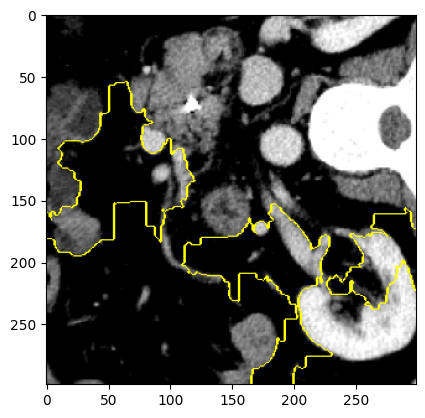

In [ ]:
temp, mask = explanation_lime.get_image_and_mask(explanation_lime.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
def heatmap_lime(explanation_lime, image, num_features, top_candidate):
    ind =  explanation_lime.top_labels[0]
    dict_heatmap_lime = dict(explanation_lime.local_exp[ind])
    heatmap_lime = np.vectorize(dict_heatmap_lime.get)(explanation_lime.segments)
    plt.imshow(heatmap_lime, cmap = 'RdBu', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
    plt.colorbar()


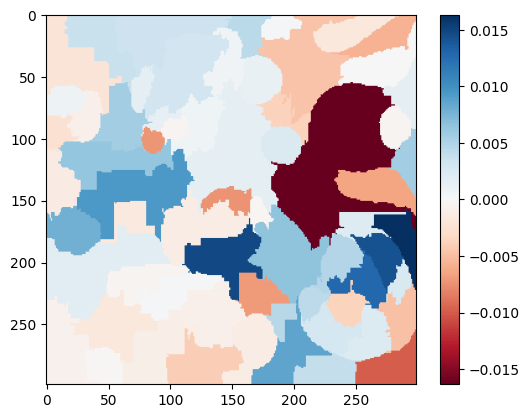

In [ ]:
heatmap_lime(explanation_lime, images, num_features=15, top_candidate=0)



---



# Grad_cam++ implementation

In [ ]:
img_path

NameError: name 'img_path' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def get_last_conv_layer_name(model, base_model_name="xception"):
    """Finds the last Conv2D/SeparableConv2D layer inside the base model (Xception)."""
    base_model = model.get_layer(base_model_name)  # Extract Functional Xception model
    for layer in reversed(base_model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
            return layer.name  # Return last Conv layer's name
    raise ValueError(f"No convolutional layers found in {base_model_name}.")



In [ ]:
def make_gradcam_heatmap(img_array, model, base_model_name="xception", pred_index=None):
    # Get the last conv layer inside Xception
    last_conv_layer_name = get_last_conv_layer_name(model, base_model_name)

    # Create model that maps input image to activations of last conv layer + predictions
    grad_model = keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(base_model_name).get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the predicted class with respect to the feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        # Ensure pred_index is an integer
        #pred_index = tf.get_static_value(pred_index).item()

        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradients over the feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the Grad-CAM heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [ ]:
def make_gradcam_batch(img_array, model, batch_size=32):
    num_images = img_array.shape[0]
    heatmaps = []

    for i in range(0, num_images, batch_size):
        batch = img_array[i : i + batch_size]  # Process a batch of images
        batch_heatmaps = make_gradcam_heatmap(batch, model)  # Call existing function
        heatmaps.append(batch_heatmaps)

    return np.vstack(heatmaps)  # Merge heatmaps from all batches


In [ ]:
heatmaps = make_gradcam_batch(images, model, batch_size=16)

NameError: name 'images' is not defined

In [ ]:
'''
def transform_img_fn(path_list, target_size):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)
'''
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps input image to activations of last conv layer + predictions
    grad_model = keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the predicted class with respect to the feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        # Ensure pred_index is an integer
        pred_index = tf.get_static_value(pred_index).item()

        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradients over the feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the Grad-CAM heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [ ]:
heatmap = make_gradcam_heatmap(images , model)

In [ ]:
images

array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-0.9843137 , -0.9843137 , -0.9843137 ]],

        ...,

        [[-0.19999999, -0.19999999, -0

In [ ]:
model_builder = keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="xception",
)
#model_builder.set_weights("imagenet") #xception.Xception(weights="imagenet")
img_size = (150, 150)
preprocess_input = xception.preprocess_input
decode_predictions = decode_predictions

# Assuming 'model' is your Keras model
layer_names = [layer.name for layer in model_builder.layers]
conv2d_layers = [name for name in layer_names if "conv2d" in name]
last_conv2d_layer_name = conv2d_layers[-1]

print(f"The last conv2d layer is: {last_conv2d_layer_name}")

last_conv_layer_name = last_conv2d_layer_name ="block14_sepconv2_act"


# The local path to our target image
img_path = path+"pos"  # Assuming the image is in the current directory.

display(Image(img_path))




In [ ]:
xception_model = model.get_layer("xception")  # Get the Xception model
xception_model.summary()  # Check its layers


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
import tensorflow as tf

last_conv_layer = None

for layer in reversed(xception_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
        last_conv_layer = layer
        break

print(f"Last Conv Layer: {last_conv_layer.name}")


Last Conv Layer: block14_sepconv2


In [ ]:
last_conv_layer_name = last_conv_layer.name


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,481,533 (238.35 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 41,618,004 (158.76 MB)

In [ ]:
# Assuming 'model' is your Keras model
layer_names = [layer.name for layer in model.layers]

# Find convolutional layers (adapt the condition if necessary)
conv2d_layers = [name for name in layer_names if "conv" in name]  # Changed to "conv"

# Check if any convolutional layers were found
if conv2d_layers:
    last_conv2d_layer_name = conv2d_layers[-1]
    print(f"The last conv2d layer is: {last_conv2d_layer_name}")
else:
    print("No convolutional layers found in the model.")
    # Handle the case where no convolutional layers are found, e.g., exit or use a different layer

No convolutional layers found in the model.


In [ ]:
preds

In [ ]:
# Prepare image
# Resize the images to the expected input shape (299, 299)
img_array = tf.image.resize(images, (299, 299))

# Make model
model = model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=5)[0])
'''
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()'''

'\n# Generate class activation heatmap\nheatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)\n\n# Display heatmap\nplt.matshow(heatmap)\nplt.show()'

In [ ]:
# Prepare image
img_array = images

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=5)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(281, 150, 150, 3)

In [ ]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

NameError: name 'heatmap' is not defined

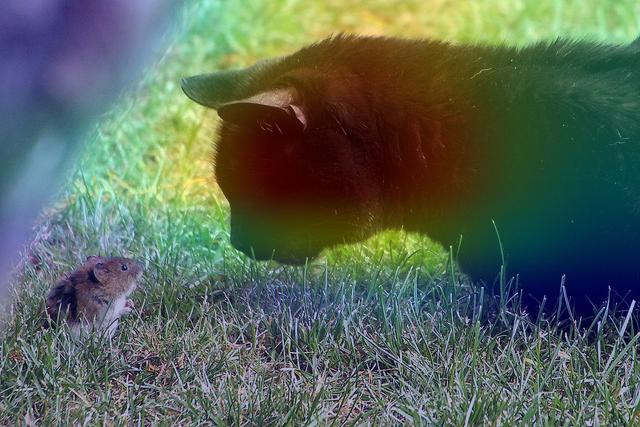

In [ ]:
save_and_display_gradcam(img_path, heatmap)

# SHAP implementation

In [ ]:
# prompt: download resnet50



# Load the ResNet50 model
model_res = tf.keras.applications.ResNet50(weights='imagenet')

print("ResNet50 model loaded successfully.")


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
ResNet50 model loaded successfully.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:42, 21.20s/it]


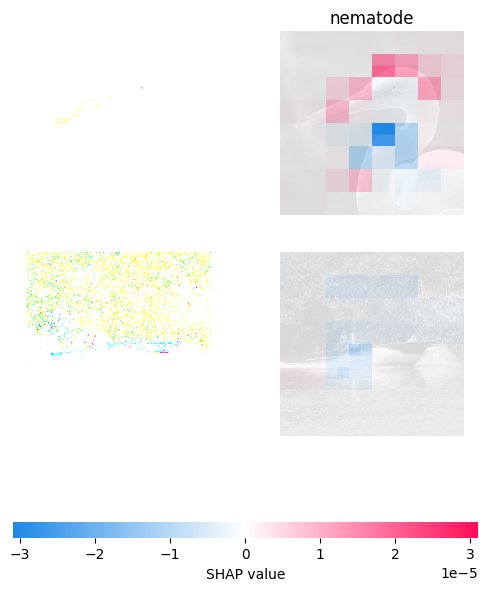

In [ ]:
import json


import shap

# load pre-trained model and choose two images to explain
model = model_res


def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)


X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [ ]:
# prompt: SHAP implemnatio

import shap

# ... (your existing code) ...

# Assuming 'model' is your Keras model and 'images' contains your image data.
# Replace with your actual model and image data.


def explain_with_shap(model, images):
    # Create a SHAP explainer
    explainer = shap.DeepExplainer(model, images)  # Use DeepExplainer for deep learning models

    # Calculate SHAP values
    shap_values = explainer.shap_values(images)

    return shap_values

shap_explanation = explain_with_shap(model_builder, images)

# Assuming shap_explanation is a list of arrays (one for each class).
# Visualize SHAP values for the top predicted class (adjust index as needed).

# Get the index of the top prediction (Example)
pred_index = np.argmax(model_builder.predict(images))

# Plot the SHAP values
shap.image_plot(shap_explanation[pred_index], -images) # Use -images to correctly plot

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_313
Received: inputs=['Tensor(shape=(1, 299, 299, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_313
Received: inputs=['Tensor(shape=(2, 299, 299, 3))']
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
import shap

# Load your pre-trained InceptionV3 model
from tensorflow.keras.applications import InceptionV3
model = InceptionV3(weights="imagenet")

# Select a few background images (for DeepExplainer, but GradientExplainer works better)
background = np.random.randn(5, 299, 299, 3) * 255  # Dummy images, replace with real ones

# Explain the prediction
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(images)

# Visualize SHAP values
shap.image_plot(shap_values, preprocess_img("cat_mouse.jpg"))


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1252
Received: inputs=['Tensor(shape=(1, 299, 299, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1252
Received: inputs=['Tensor(shape=(50, 299, 299, 3))']
  warnings.warn(msg)
